In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def parse_segmented_csv(path):
    """
    Reads a CSV where each sample is a segment:
      - Header row: sample ID + tool names
      - Following rows: iteration number, values for each tool
      - 'avg' row per segment (dropped) and blank rows (dropped)
    Returns a long-form DataFrame: sample, iteration, tool, value.
    """
    df = pd.read_csv(path, header=None, dtype=str, keep_default_na=False)
    # Drop fully blank rows
    df = df[~df.apply(lambda row: all(cell.strip()=='' for cell in row), axis=1)]
    # Identify header rows: first col not a digit and not 'avg'
    header_mask = ~df[0].str.isdigit() & (df[0].str.lower() != 'avg')
    header_idxs = df.index[header_mask].tolist()
    
    records = []
    for idx_i, hdr in enumerate(header_idxs):
        row = df.loc[hdr].tolist()
        sample = row[0].strip()
        tools = [t.strip() for t in row[1:]]
        start = hdr + 1
        end = header_idxs[idx_i+1] if idx_i+1 < len(header_idxs) else df.index.max() + 1
        segment = df.loc[start:end-1]
        # Drop 'avg' rows
        segment = segment[segment[0].str.lower() != 'avg']
        for _, segrow in segment.iterrows():
            iteration = segrow[0].strip()
            for c, tool in enumerate(tools, start=1):
                val = segrow[c].strip()
                records.append({
                    'sample': sample,
                    'iteration': iteration,
                    'tool': tool,
                    'value': val
                })
    return pd.DataFrame(records)

# Parse CPU and RAM
cpu_long = parse_segmented_csv('../results/cpu_ram/runtime_data - ALL CPU DATA.csv')
ram_long = parse_segmented_csv('../results/cpu_ram/runtime_data - ALL_RAM_DATA.csv')

# Safe CPU conversion with logging
bad_cpu = []
def safe_hms_to_seconds(t):
    try:
        h, m, s = t.split(':')
        return int(h)*3600 + int(m)*60 + float(s)
    except Exception:
        bad_cpu.append(t)
        return np.nan

cpu_long['cpu_seconds'] = cpu_long['value'].apply(safe_hms_to_seconds)

print("Malformed CPU time strings:", set(bad_cpu))
print("Rows with parsing failures:")
print(cpu_long[cpu_long['cpu_seconds'].isna()])

# Drop failures
cpu_long = cpu_long.dropna(subset=['cpu_seconds'])

# Safe RAM conversion with logging
bad_ram = []
def safe_mem_to_gb(x):
    try:
        m = re.match(r'([\d\.]+)\s*([MG]B)', x.strip(), re.I)
        v, unit = m.groups()
        v = float(v)
        return v if unit.upper()=='GB' else v/1024
    except Exception:
        bad_ram.append(x)
        return np.nan

ram_long['ram_gb'] = ram_long['value'].apply(safe_mem_to_gb)

print("Malformed RAM strings:", set(bad_ram))
print("Rows with parsing failures:")
print(ram_long[ram_long['ram_gb'].isna()])

# Drop failures
ram_long = ram_long.dropna(subset=['ram_gb'])



cpu_long
ram_long



Malformed CPU time strings: set()
Rows with parsing failures:
Empty DataFrame
Columns: [sample, iteration, tool, value, cpu_seconds]
Index: []
Malformed RAM strings: set()
Rows with parsing failures:
Empty DataFrame
Columns: [sample, iteration, tool, value, ram_gb]
Index: []


,sample,iteration,tool,value,ram_gb
0,ERR009159,1,seq2HLA,73.48 MB,0.071758
1,ERR009159,1,rna2hla,96.89 MB,0.094619
2,ERR009159,1,arcasHLA,2.39 GB,2.390000
3,ERR009159,1,HLAforest,4.60 GB,4.600000
4,ERR009159,1,Optitype,13.47 GB,13.470000
...,...,...,...,...,...
1435,GSM3768245,10,HLA-HD,1.45 GB,1.450000
1436,GSM3768245,10,HLAvbseq,1.85 GB,1.850000
1437,GSM3768245,10,T1K,1.88 GB,1.880000
1438,GSM3768245,10,HISAT-genotype,7.37 GB,7.370000


/tmp/ipykernel_2205049/4116766822.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cpu_groups, labels=cpu_long['tool'].unique())


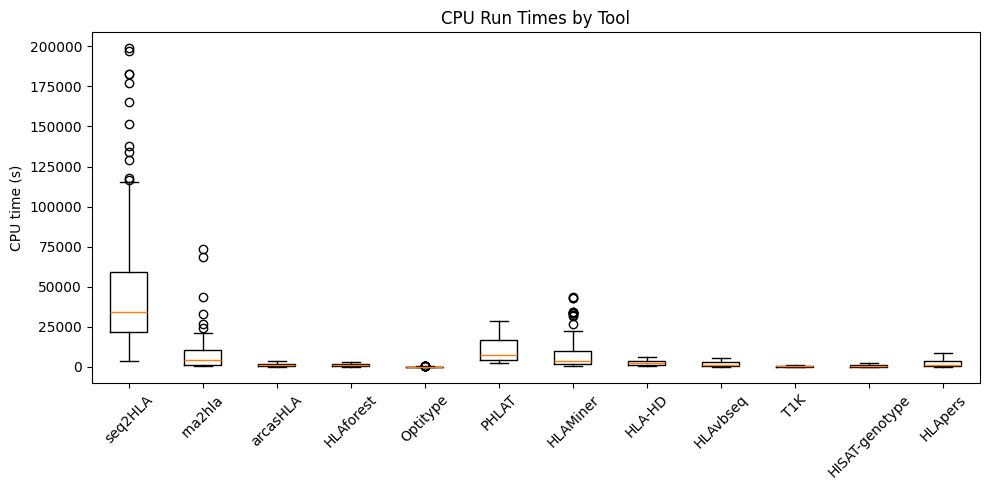

/tmp/ipykernel_2205049/4116766822.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ram_groups, labels=ram_long['tool'].unique())


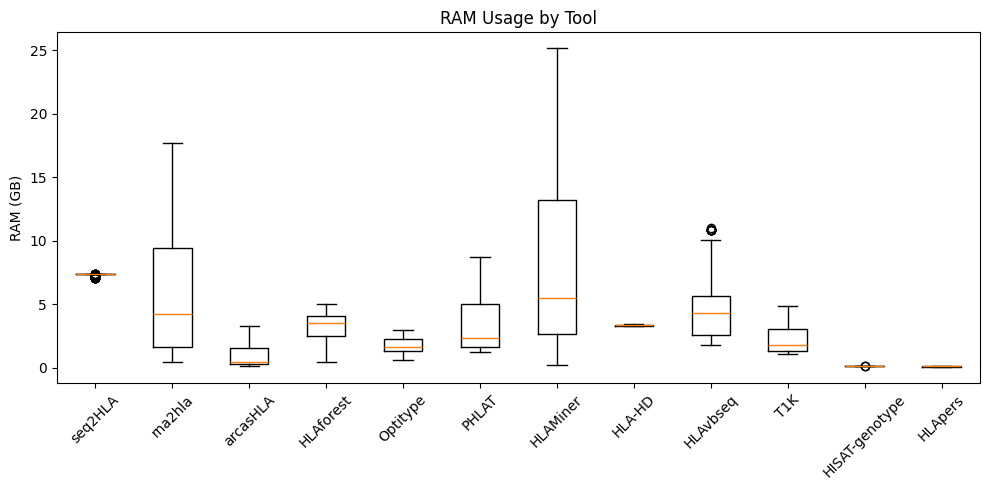